# Code test for the numerical solution in the 2D case

In [1]:
from numpy import *
import numpy as np
import math
from mpmath import *
import scipy.integrate
import scipy
import glob
import os.path
import sys
import os
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import numpy.ma as ma
from matplotlib.colors import LogNorm
import scipy.linalg
# Library for precompiled (and faster) code
import numba as numba
from numba import njit

In [2]:
def global_variables ():
    # some useful variables for the figures
    global axisticslabelfontsize
    global axisticslabelfontsizeinset
    global axislabelfontsize
    global axislabelfontsizeinset
    global legendfontsize
    global lineswidth
    axisticslabelfontsize=9
    axisticslabelfontsizeinset=7
    axislabelfontsize=11
    axislabelfontsizeinset=9
    legendfontsize=7
    lineswidth = 2
    return

def fmt(x, pos):
    # format for colorbars tick labels
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [3]:
@njit(fastmath=True)    
def U(x,y):
    # potential energy function
    ky = 20.
    kx = 6.5
    x0 = 1.
    return (ky/2.)*y**2 + kx*(x**2-x0**2)**2

@njit(fastmath=True)    
def F(x,y):
    # x-component of the force
    kx = 6.5
    x0 = 1.
    # y-component of the force
    ky = 20.
    fx = -4*kx*(x**2-x0**2)*x
    fy = -ky*y
    return fx, fy

@njit(fastmath=True)
def state(x,y): #State of the point. If in reactant or product = 1, otherwise = 0
    state = 0
    Pot = U(x,y)
    if Pot < 2:
        state = 1 #
    return state    

In [4]:
def plot_comm(x,y,q):
    with PdfPages('comm2d_fixedb_doubleMD.pdf') as pdf:
        fmt1 = '%r %%'
        fig = plt.figure(figsize=(4.,2.8),dpi=600)
        plt.rc('text')
        panel = fig.add_axes([0.15, 0.15, 0.72, 0.75]) # dimensions and location of the panel within the figure
        cmap = plt.get_cmap('jet') # choose colormap for the committor
        pcm = panel.pcolormesh(x, y, q.T, cmap=cmap,zorder=0,vmin = 0., vmax = 1.) # plot the committor in the grid
        cbar = plt.colorbar(pcm,format=ticker.FuncFormatter(fmt)) # plot colorbar and select format
        cbar.ax.tick_params(labelsize=axisticslabelfontsize-2) # dimension of the labels of the colorbar
        panel.set_xlabel(r'$x$',fontsize=axislabelfontsize,labelpad=2) # labels and ticklabels along x with their fontsize and location, x limits and same for y below
        for tick in panel.xaxis.get_major_ticks(): tick.label.set_fontsize(axisticslabelfontsize)
        panel.set_xlim(-3.1,3.1)
        panel.xaxis.set_major_locator(MultipleLocator(1))
        panel.xaxis.set_minor_locator(MultipleLocator(0.2))
        panel.set_ylabel(r'$y$',fontsize=axislabelfontsize,labelpad=2)
        for tick in panel.yaxis.get_major_ticks(): tick.label.set_fontsize(axisticslabelfontsize)
        panel.set_ylim(-3.1,3.1)
        panel.yaxis.set_major_locator(MultipleLocator(1))
        panel.yaxis.set_minor_locator(MultipleLocator(0.2))
        panel.text(-0.5,3.3,r"$q(x,y)$") # title
        levelsb = [0.,2.] # basins R and P, defined by having energy smaller than 2k_{B}T
        levels = [0.,4.,6.,10.,20.,50.,100.,200.] # energy lines to plot
        u = np.linspace(-3.,3.,200)  # x and y to plot the energy landscape on top of the committor
        v = np.linspace(-3.,3.,200)
        u,v = np.meshgrid(u,v)
        w = 0.5*20.*(v)**2 + 6.5*((u)**2-1.)**2 # energy for each couple of values (x,y)
        contour = panel.contour(u,v,w,levels=levelsb,colors="white",linewidths = 0.5,zorder=2) #contour plots for the basin, with energy value plot inline
        panel.clabel(contour,contour.levels,inline=True,fmt=fmt1,fontsize=5)
        contour1 = panel.contour(u,v,w,levels=levels,colors="black",linewidths = 0.5,zorder=1) #contour plots for the energy lines set above with levels, with energy value plot inline
        panel.clabel(contour1,contour1.levels,inline=True,fmt=fmt1,fontsize=5)
        pdf.savefig(fig)

In [5]:
global_variables()
x = np.linspace(-3.,3.,50) # dimension of the grid along each axis, 50 points in range [-3;3]
y = np.linspace(-3.,3.,50)
d = 0.1 # diffusion coefficient
beta = 1. # 1/k_{B}T
dx = x[1]-x[0] # step of the grid along the x direction
dy = y[1]-y[0] # step of the grid along the y direction
I = len(x)-1 # index of the last cell along x
J = len(y)-1 # index of the last cell along y
N = I*(J+1)+J # index of the last cell in the 1D vector that contains all the I*(J+1)+J+1 = N+1 cells in the system
q = np.zeros(shape=(N+1)) # vector that contains the N+1 values of the committor for each grid point
P = np.zeros(shape=(N+1,N+1)) # matrix with (N+1)*(N+1) elements, that determines the linear system to solve P*q = R
R = np.zeros(shape=(N+1)) # vector with the N+1 elements of results of the backward F-P equation
dt = 0.01 # time interval for MD simulations
bd = 0 # counter for boundary points on which the MD is finished

## Precompute some coefficients
D1 = d*beta*dt
D2 = np.sqrt(2.*d*dt)


# construction of P and R
i = 0
while i < len(x):
    xp = x[i]
    j = 0
    while j < len(y):
        yp = y[j]
        Fx, Fy = F(xp,yp)
        n = i*(J+1)+j					# for each grid point i,j computes the corresponding index n in the 1D vectors and computes the coefficients A,B,C,D,E
        A = d/(dx**2) + (beta*d*Fx)/(2*dx)
        B = 2*d/(dx**2) + 2*d/(dy**2)
        C = d/(dx**2) - (beta*d*Fx)/(2*dx)
        D = d/(dy**2) + (beta*d*Fy)/(2*dy)
        E = d/(dy**2) - (beta*d*Fy)/(2*dy)
        if state(xp,yp) != 0:				# if you are inside the reactant basin or the product basin impose boundary condition of q = 0 in Reactant and q = 1 in Product
            P[n,n] = 1.
            if xp > 0.:
                R[n] = 1.
        elif ((i == 0) or (i == I)):	# if you are on the two boundaries along x, do MD simulations for each boundary point to find the committor on the edges of the grid
            t = 0
            nr = 0
            nt = 0
            while t < 1000:				# 1000 trajectories for each point
                xi = x[i]				# for each trajectory in a given grid point on the edge, set as initial conditions the coordinates of that grid point
                yi = y[j]
                k = 0
                while (state(xi,yi)==0 and k < 5000):	# keep evolving the system untill you enter in Reactant or Product
                    Fx, Fy = F(xi,yi)
                    xf = xi + Fx*D1 + D2*np.random.normal(loc=0.,scale=1.)	# evolve x and y with the equations of motion for a passive particle performing brownian motion in a potential energy landscape
                    yf = yi + Fy*D1 + D2*np.random.normal(loc=0.,scale=1.)
                    xi = xf
                    yi = yf
                    k += 1
                if xf < 0.:				# if you enter in Reactant
                    nr += 1
                elif xf > 0.:			# if you enter in Product
                    nt += 1
                t += 1
            if t != (nt+nr):			# just a check
                print("Something wrong occurred during MD simulation!")
            bd += 1
            print(bd)					# print the index of the boundary point in which you finished the MD simulations
            P[n,n] = 1.
            R[n] = nt/(nt+nr)			# value of the committor in that point
        elif ((i != 0) and (i != I) and ( (j == 0) or (j == J) )):		# if you are on the boundaries along y do MD simulation for each grid point on the boundary, except those included in the boundaries of x that are already done
            t = 0
            nr = 0
            nt = 0
            while t < 1000:
                xi = x[i]
                yi = y[j]
                k = 0
                while (state(xi,yi)==0 and k < 5000):
                    Fx, Fy = F(xi,yi)
                    xf = xi + Fx*D1 + D2*np.random.normal(loc=0.,scale=1.)
                    yf = yi + Fy*D1 + D2*np.random.normal(loc=0.,scale=1.)
                    xi = xf
                    yi = yf
                    k += 1
                if xf < 0.:
                    nr += 1
                elif xf > 0.:
                    nt += 1
                t += 1
            if t != (nt+nr):
                print("Something wrong occurred during MD simulation!")
            bd += 1
            print(bd)
            P[n,n] = 1.
            R[n] = nt/(nt+nr)
        else:							# if you are in every other point of the grid fill the P matrix according to the usual pattern
            P[n,(i-1)*(J+1)+j] = C
            P[n,i*(J+1)+j-1] = E
            P[n,i*(J+1)+j] = -B
            P[n,i*(J+1)+j+1] = D
            P[n,(i+1)*(J+1)+j] = A
        j+=1
    i+=1
    
print("System initialized")

q = scipy.linalg.solve(P,R)				# solve linear system to find the committor
for el in q:
    if el > 1.:							# some errors in the solution of the system are inevitable, so don't mind if you get some of these errors, as long as the values of the committor are not too much larger than 1 or too much smaller than 0
        print("Error! Committor larger than 1!")
    elif el < 0.:
        print("Error! Committor smaller than 0!")
q = np.reshape(q,(I+1,J+1))				# reshape the committor from 1D vector to 2D grid

print(q)

xplot = np.empty(shape=(len(x)+1))		# set x and y coordinates for the edges of the bins in the grid
yplot = np.empty(shape=(len(y)+1))
k=0
for el in x:
    xplot[k] = x[k]-(dx/2.)
    k+=1
xplot[len(x)] = x[len(x)-1]+(dx/2.)
k=0
for el in y:
    yplot[k] = y[k]-(dy/2.)
    k+=1
yplot[len(y)] = y[len(y)-1]+(dy/2.)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
System initialized
Error! Committor smaller than 0!
Error! Committor smaller than 0!
Error! Committor smaller than 0!
Error! Committor smaller than 0!
Error! Committor smaller than 0!
Error! Committor smaller than 0!
Error! Committor smaller than 0!
Error! Committor smaller than 0!
Error! Committor smaller than 0!
Error! C

In [6]:
xplot = np.empty(shape=(len(x)+1))		# set x and y coordinates for the edges of the bins in the grid
yplot = np.empty(shape=(len(y)+1))
k=0
for el in x:
    xplot[k] = x[k]-(dx/2.)
    k+=1
xplot[len(x)] = x[len(x)-1]+(dx/2.)
k=0
for el in y:
    yplot[k] = y[k]-(dy/2.)
    k+=1
yplot[len(y)] = y[len(y)-1]+(dy/2.)

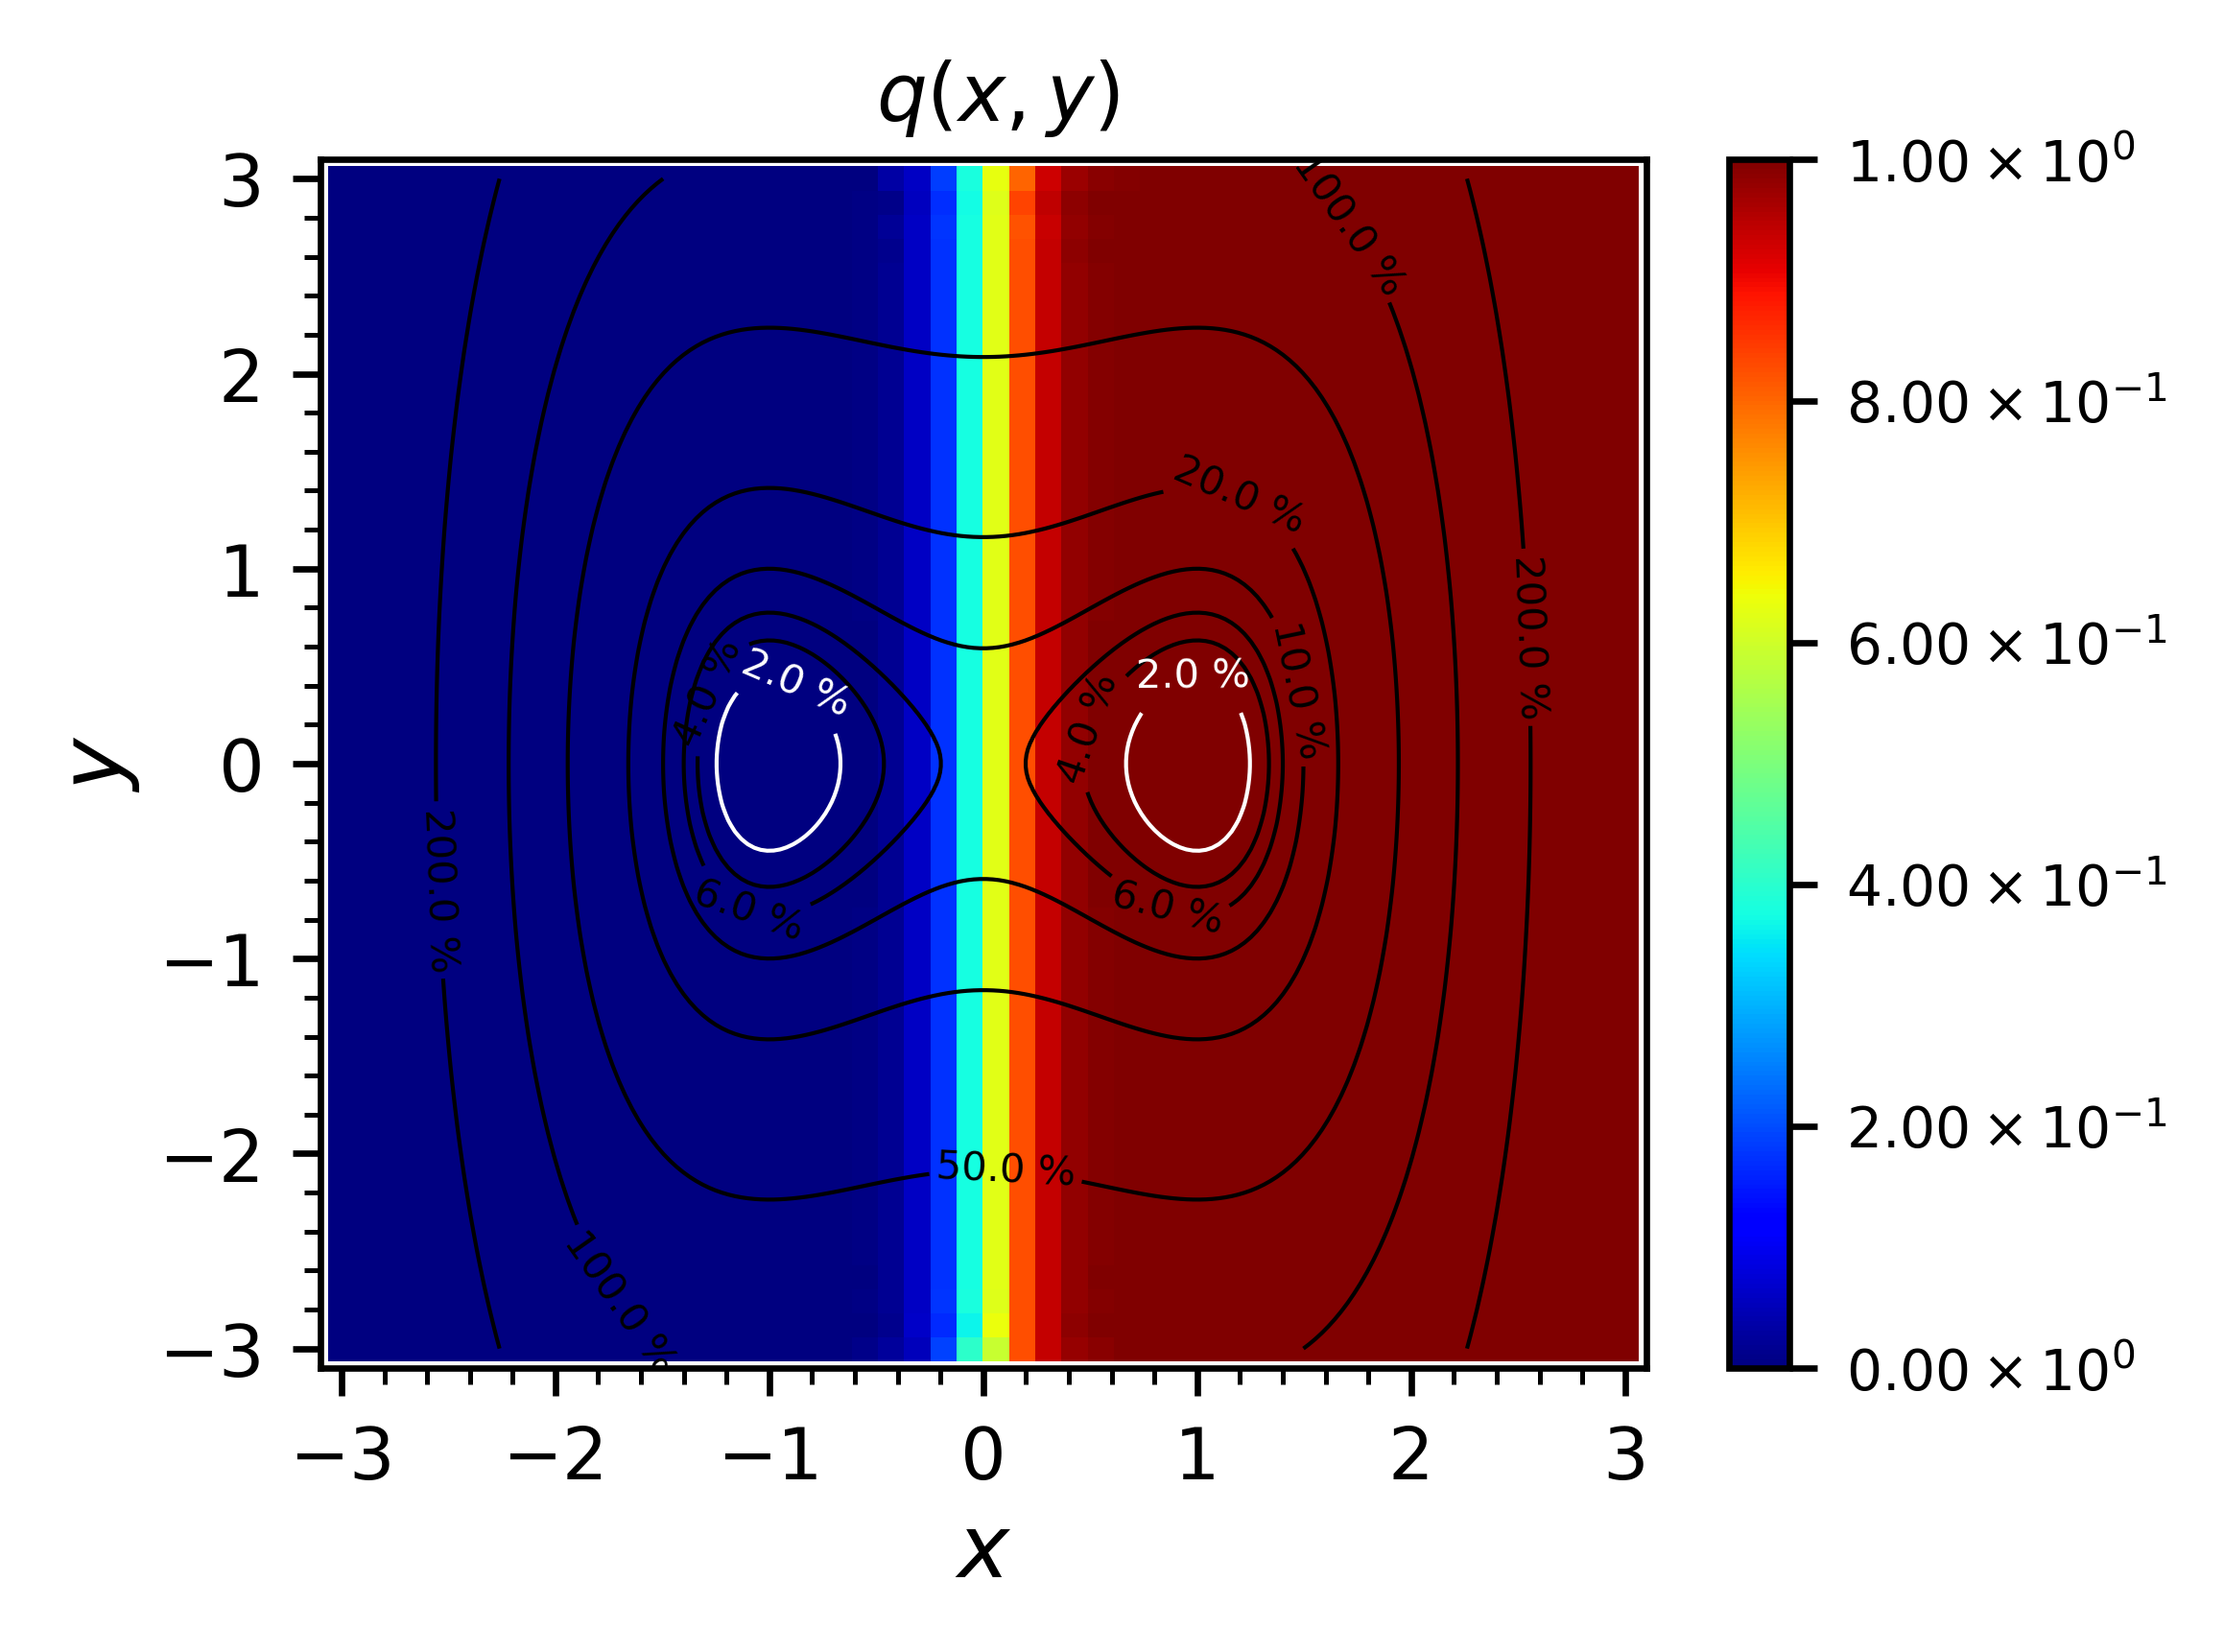

In [7]:
plot_comm(xplot,yplot,q)      # plot the committor